<a href="https://colab.research.google.com/github/DevLucasMelloo/Dados_SQL/blob/main/Dados_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, inspect, text

In [2]:
url_itens_pedidos = 'https://raw.githubusercontent.com/DevLucasMelloo/Dados_SQL/refs/heads/main/itens_pedidos.csv'
url_pedidos = 'https://raw.githubusercontent.com/DevLucasMelloo/Dados_SQL/refs/heads/main/pedidos.csv'
url_produtos = 'https://raw.githubusercontent.com/DevLucasMelloo/Dados_SQL/refs/heads/main/produtos.csv'
url_vendedores = 'https://raw.githubusercontent.com/DevLucasMelloo/Dados_SQL/refs/heads/main/vendedores.csv'

In [3]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produtos)
vendedores = pd.read_csv(url_vendedores)

# Criação banco de dados

In [4]:
#Criando um banco de dados local

engine = create_engine('sqlite:///:memory:')

In [5]:
#Adicionar tabelas no banco de dados

produtos.to_sql('produtos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [6]:
# Inspeção

inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# Trabalhando os dados

In [7]:
#Fazendo consulta

query = 'SELECT CONDICAO FROM PRODUTOS'

In [8]:
#Criando função para executar uma query

def sql_df(query):
  with engine.connect() as conexao:
      consulta = conexao.execute(text(query))
      dados = consulta.fetchall()
  return pd.DataFrame(dados, columns=consulta.keys())

In [9]:
#Query com agrupamento por frequencia de produtos

query = '''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO;'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


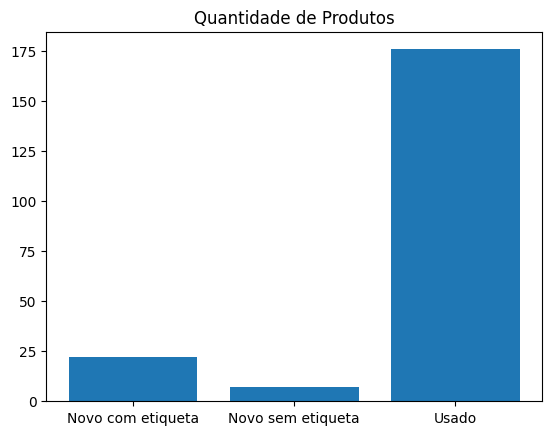

In [10]:
#Criando uam visualização gráfica

plt.bar(df_produtos['Condicao'],df_produtos['Quantidade'])
plt.title('Quantidade de Produtos')
plt.show()

# Produtos mais comprados por quantidade

In [11]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [12]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [13]:
#Criando relação entre produtos e itens pedidos

query = '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS 'quantidade'
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC'''

df_prod_quant = sql_df(query)
df_prod_quant

,produto,quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


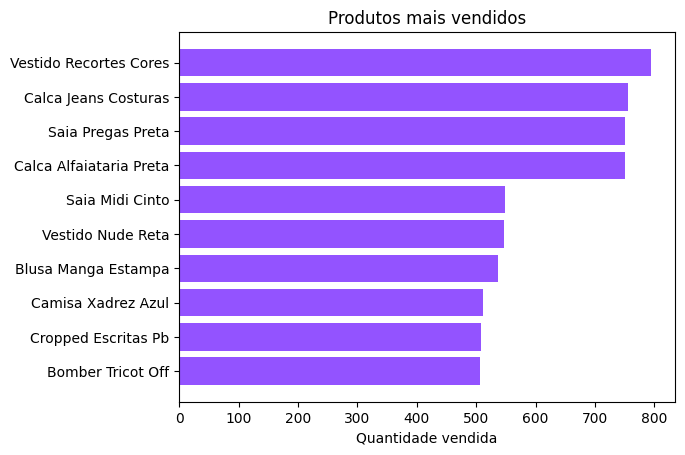

In [14]:
plt.barh(df_prod_quant['produto'][-10:],df_prod_quant['quantidade'][-10:], color='#9353FF')
plt.title('Produtos mais vendidos')
plt.xlabel('Quantidade vendida')
plt.show()

# Desempenho de vendedores em 2020

In [15]:
sql_df('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [16]:
#Tipo das colunas
sql_df('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


In [17]:
# Criando filtro de vendas por vendedor em 2020
query = '''SELECT VENDEDORES.NOME_VENDEDOR,  AVG(PEDIDOS.TOTAL) AS valor_de_vendas_medio
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY  AVG(PEDIDOS.TOTAL) DESC;
'''
sql_df(query)

,nome_vendedor,valor_de_vendas_medio
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


# Incrementação de vendas em SP

In [18]:
#Estado que mais vende
query = '''SELECT ESTADO, COUNT(*) AS pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY pedidos DESC;
'''

sql_df(query)

,Estado,pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


In [27]:
#Visualização de vendas de cada vendedor em SP
query = '''SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) AS quantidade_vendas
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY quantidade_vendas DESC;
'''

sql_df(query)

,nome_vendedor,quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157
